In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):
    def __init__(self, root, split, transform=None, feature_extractor=None, version='0.1'):
        super().__init__(root=root, split=split, transform=transform)
        self.feature_extractor = feature_extractor  # Function to extract features
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        # Cache file path
        cache_path = self._get_cache_path(index)

        # Load feature from cache if it exists

        img = img.unsqueeze(0)  # Add batch dimension
        grayscale_img_rgb = F.rgb_to_grayscale(img, num_output_channels=3).to(device)
        features_path = os.path.join(self.cache_dir, f'feature_{index}.pt')

        if os.path.exists(cache_path):
            saved_features = torch.load(cache_path).to(device)
            if random() < 0.01: # check if the cache is correct
                features = None
                def assign_features(module, input, output):
                    nonlocal features
                    features = output
                hook = self.resnet_layer.register_forward_hook(assign_features)
                
                with torch.no_grad():
                    self.resnet50(grayscale_img_rgb)
                hook.remove()
                assert features is not None
                features = features.squeeze(0)

                assert torch.equal(saved_features, features)
            features = saved_features

        else:
            # Compute feature if not cached

            features = None
            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(grayscale_img_rgb)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)

            torch.save(features, cache_path)  # Save to cache
        
        # center crop
        target = F.rgb_to_grayscale(img, num_output_channels=1).squeeze(0)
        return features, target
# Image transformations
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Example feature extractor: compute mean/std per channel

def feature_extractor(img):
    img_np = np.array(img)
    mean = np.mean(img_np, axis=(0, 1))
    std = np.std(img_np, axis=(0, 1))
    return torch.tensor(np.concatenate([mean, std]))
# Dataset path


# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='train',
    transform=train_transforms,
    feature_extractor=feature_extractor,
    version='0.7'
)

# Define the image limit
BATCH_SIZE = 1024
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 20 * BATCH_SIZE
LOSS_EVERY = 10
EPOCH = 1

assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 20 batches.


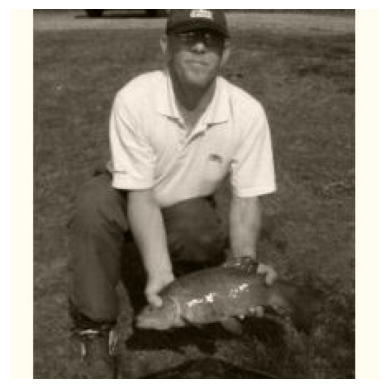

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet normalization mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet normalization std
    img = std * img + mean  # De-normalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
show_image(targets[0])  # Show the first image in the batch

In [4]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.trans_conv1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=64,
            kernel_size=8, stride=8, padding=0
        )
        self.trans_conv2 = nn.ConvTranspose2d(
            in_channels=64, out_channels=1,
            kernel_size=4, stride=2, padding=1
        )
    
    def forward(self, x):
        x = self.trans_conv1(x)  # Output shape: (64, 112, 112)
        x = self.trans_conv2(x)  # Output shape: (1, 224, 224)
        return x

# Example usage:
model = UpsampleModel()
input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Should print torch.Size([1, 1, 224, 224])
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


torch.Size([1, 1, 224, 224])
Total parametrs:  4195393


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [6]:
num_epochs = 1
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(num_epochs):

    # for grayscale_img, features, target in tqdm(train_loader):
    for i, (features, target) in enumerate(tqdm(train_loader)):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)

        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY-1:
            losses.append(running_loss/LOSS_EVERY)
            running_loss = 0.0

        constant_guess_loss = criterion(torch.full_like(target, 0), target)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:07<59:44,  7.18s/it]

  0%|          | 2/500 [00:15<1:03:43,  7.68s/it]

  1%|          | 3/500 [00:22<1:01:21,  7.41s/it]

  1%|          | 4/500 [00:30<1:02:56,  7.61s/it]

  1%|          | 5/500 [00:38<1:04:08,  7.77s/it]

  1%|          | 6/500 [00:46<1:04:21,  7.82s/it]

  1%|▏         | 7/500 [00:54<1:06:30,  8.09s/it]

  2%|▏         | 8/500 [01:03<1:08:00,  8.29s/it]

  2%|▏         | 9/500 [01:12<1:08:20,  8.35s/it]

  2%|▏         | 10/500 [01:20<1:08:14,  8.36s/it]

  2%|▏         | 11/500 [01:29<1:09:10,  8.49s/it]

  2%|▏         | 12/500 [01:37<1:09:11,  8.51s/it]

  3%|▎         | 13/500 [01:46<1:10:45,  8.72s/it]

  3%|▎         | 14/500 [01:54<1:07:18,  8.31s/it]

  3%|▎         | 15/500 [02:02<1:05:43,  8.13s/it]

  3%|▎         | 16/500 [02:09<1:05:07,  8.07s/it]

  3%|▎         | 17/500 [02:17<1:03:34,  7.90s/it]

  4%|▎         | 18/500 [02:25<1:02:57,  7.84s/it]

  4%|▍         | 19/500 [02:33<1:03:36,  7.93s/it]

  4%|▍         | 20/500 [02:41<1:04:11,  8.02s/it]

  4%|▍         | 21/500 [02:48<1:02:31,  7.83s/it]

  4%|▍         | 22/500 [02:56<1:01:00,  7.66s/it]

  5%|▍         | 23/500 [03:04<1:03:23,  7.97s/it]

  5%|▍         | 24/500 [03:12<1:03:25,  7.99s/it]

  5%|▌         | 25/500 [03:20<1:01:43,  7.80s/it]

  5%|▌         | 26/500 [03:27<1:01:21,  7.77s/it]

  5%|▌         | 27/500 [03:36<1:02:58,  7.99s/it]

  6%|▌         | 28/500 [03:45<1:05:01,  8.27s/it]

  6%|▌         | 29/500 [03:56<1:10:29,  8.98s/it]

  6%|▌         | 30/500 [04:07<1:16:09,  9.72s/it]

  6%|▌         | 31/500 [04:19<1:21:09, 10.38s/it]

  6%|▋         | 32/500 [04:32<1:26:55, 11.14s/it]

  7%|▋         | 33/500 [04:43<1:25:58, 11.05s/it]

  7%|▋         | 34/500 [04:54<1:25:19, 10.99s/it]

  7%|▋         | 35/500 [05:05<1:26:16, 11.13s/it]

  7%|▋         | 36/500 [05:18<1:29:46, 11.61s/it]

  7%|▋         | 37/500 [05:29<1:28:34, 11.48s/it]

  8%|▊         | 38/500 [05:40<1:27:08, 11.32s/it]

  8%|▊         | 39/500 [05:51<1:26:03, 11.20s/it]

  8%|▊         | 40/500 [06:02<1:26:57, 11.34s/it]

  8%|▊         | 41/500 [06:13<1:26:05, 11.25s/it]

  8%|▊         | 42/500 [06:26<1:29:26, 11.72s/it]

  9%|▊         | 43/500 [06:37<1:27:01, 11.43s/it]

  9%|▉         | 44/500 [06:47<1:23:06, 10.94s/it]

  9%|▉         | 45/500 [07:01<1:31:28, 12.06s/it]

  9%|▉         | 46/500 [07:12<1:28:04, 11.64s/it]

  9%|▉         | 47/500 [07:25<1:30:15, 11.96s/it]

 10%|▉         | 48/500 [07:39<1:35:29, 12.68s/it]

 10%|▉         | 49/500 [07:50<1:32:00, 12.24s/it]

 10%|█         | 50/500 [08:02<1:30:16, 12.04s/it]

 10%|█         | 51/500 [08:14<1:29:55, 12.02s/it]

 10%|█         | 52/500 [08:25<1:28:17, 11.82s/it]

 11%|█         | 53/500 [08:36<1:26:23, 11.60s/it]

 11%|█         | 54/500 [08:48<1:26:02, 11.57s/it]

 11%|█         | 55/500 [08:59<1:25:50, 11.57s/it]

 11%|█         | 56/500 [09:11<1:25:07, 11.50s/it]

 11%|█▏        | 57/500 [09:22<1:24:33, 11.45s/it]

 12%|█▏        | 58/500 [09:34<1:25:09, 11.56s/it]

 12%|█▏        | 59/500 [09:45<1:23:36, 11.37s/it]

 12%|█▏        | 60/500 [09:55<1:21:36, 11.13s/it]

 12%|█▏        | 61/500 [10:07<1:23:20, 11.39s/it]

 12%|█▏        | 62/500 [10:19<1:23:18, 11.41s/it]

 13%|█▎        | 63/500 [10:30<1:22:31, 11.33s/it]

 13%|█▎        | 64/500 [10:42<1:23:27, 11.49s/it]

 13%|█▎        | 65/500 [10:54<1:24:37, 11.67s/it]

 13%|█▎        | 66/500 [11:06<1:24:24, 11.67s/it]

 13%|█▎        | 67/500 [11:17<1:24:16, 11.68s/it]

 14%|█▎        | 68/500 [11:30<1:25:20, 11.85s/it]

 14%|█▍        | 69/500 [11:42<1:26:23, 12.03s/it]

 14%|█▍        | 70/500 [11:55<1:27:14, 12.17s/it]

 14%|█▍        | 71/500 [12:07<1:27:22, 12.22s/it]

 14%|█▍        | 72/500 [12:19<1:25:55, 12.05s/it]

 15%|█▍        | 73/500 [12:29<1:22:56, 11.65s/it]

 15%|█▍        | 74/500 [12:41<1:23:17, 11.73s/it]

 15%|█▌        | 75/500 [12:52<1:21:01, 11.44s/it]

 15%|█▌        | 76/500 [13:03<1:19:55, 11.31s/it]

 15%|█▌        | 77/500 [13:13<1:17:45, 11.03s/it]

 16%|█▌        | 78/500 [13:25<1:18:37, 11.18s/it]

 16%|█▌        | 79/500 [13:37<1:19:32, 11.34s/it]

 16%|█▌        | 80/500 [13:48<1:18:41, 11.24s/it]

 16%|█▌        | 81/500 [13:58<1:17:40, 11.12s/it]

 16%|█▋        | 82/500 [14:10<1:17:28, 11.12s/it]

 17%|█▋        | 83/500 [14:23<1:21:28, 11.72s/it]

 17%|█▋        | 84/500 [14:34<1:21:07, 11.70s/it]

 17%|█▋        | 85/500 [14:45<1:19:18, 11.47s/it]

 17%|█▋        | 86/500 [14:57<1:20:05, 11.61s/it]

 17%|█▋        | 87/500 [15:09<1:21:04, 11.78s/it]

 18%|█▊        | 88/500 [15:22<1:23:04, 12.10s/it]

 18%|█▊        | 89/500 [15:35<1:23:17, 12.16s/it]

 18%|█▊        | 90/500 [15:46<1:21:09, 11.88s/it]

 18%|█▊        | 91/500 [15:56<1:17:53, 11.43s/it]

 18%|█▊        | 92/500 [16:07<1:16:52, 11.30s/it]

 19%|█▊        | 93/500 [16:18<1:15:07, 11.07s/it]

 19%|█▉        | 94/500 [16:29<1:15:57, 11.22s/it]

 19%|█▉        | 95/500 [16:41<1:17:01, 11.41s/it]

 19%|█▉        | 96/500 [16:52<1:16:21, 11.34s/it]

 19%|█▉        | 97/500 [17:05<1:18:35, 11.70s/it]

 20%|█▉        | 98/500 [17:16<1:18:18, 11.69s/it]

 20%|█▉        | 99/500 [17:28<1:18:28, 11.74s/it]

 20%|██        | 100/500 [17:39<1:16:30, 11.48s/it]

 20%|██        | 101/500 [17:50<1:15:19, 11.33s/it]

 20%|██        | 102/500 [18:01<1:13:17, 11.05s/it]

 21%|██        | 103/500 [18:11<1:11:24, 10.79s/it]

 21%|██        | 104/500 [18:21<1:10:37, 10.70s/it]

 21%|██        | 105/500 [18:34<1:13:43, 11.20s/it]

 21%|██        | 106/500 [18:46<1:15:21, 11.48s/it]

 21%|██▏       | 107/500 [18:56<1:13:42, 11.25s/it]

 22%|██▏       | 108/500 [19:07<1:11:55, 11.01s/it]

 22%|██▏       | 109/500 [19:18<1:12:04, 11.06s/it]

 22%|██▏       | 110/500 [19:30<1:13:21, 11.29s/it]

 22%|██▏       | 111/500 [19:40<1:11:17, 11.00s/it]

 22%|██▏       | 112/500 [19:52<1:12:32, 11.22s/it]

 23%|██▎       | 113/500 [20:04<1:14:34, 11.56s/it]

 23%|██▎       | 114/500 [20:15<1:12:58, 11.34s/it]

 23%|██▎       | 115/500 [20:26<1:10:53, 11.05s/it]

 23%|██▎       | 116/500 [20:37<1:12:22, 11.31s/it]

 23%|██▎       | 117/500 [20:49<1:12:46, 11.40s/it]

 24%|██▎       | 118/500 [21:01<1:12:52, 11.45s/it]

 24%|██▍       | 119/500 [21:11<1:11:10, 11.21s/it]

 24%|██▍       | 120/500 [21:23<1:11:50, 11.34s/it]

 24%|██▍       | 121/500 [21:33<1:09:28, 11.00s/it]

 24%|██▍       | 122/500 [21:43<1:08:02, 10.80s/it]

 25%|██▍       | 123/500 [21:54<1:06:56, 10.65s/it]

 25%|██▍       | 124/500 [22:05<1:07:35, 10.79s/it]

 25%|██▌       | 125/500 [22:16<1:07:57, 10.87s/it]

 25%|██▌       | 126/500 [22:27<1:08:25, 10.98s/it]

 25%|██▌       | 127/500 [22:38<1:08:09, 10.96s/it]

 26%|██▌       | 128/500 [22:49<1:07:14, 10.85s/it]

 26%|██▌       | 129/500 [22:59<1:05:55, 10.66s/it]

 26%|██▌       | 130/500 [23:11<1:07:34, 10.96s/it]

 26%|██▌       | 131/500 [23:21<1:07:10, 10.92s/it]

 26%|██▋       | 132/500 [23:32<1:06:47, 10.89s/it]

 27%|██▋       | 133/500 [23:45<1:09:34, 11.37s/it]

 27%|██▋       | 134/500 [23:58<1:12:48, 11.94s/it]

 27%|██▋       | 135/500 [24:09<1:11:04, 11.68s/it]

 27%|██▋       | 136/500 [24:21<1:11:03, 11.71s/it]

 27%|██▋       | 137/500 [24:33<1:10:54, 11.72s/it]

 28%|██▊       | 138/500 [24:46<1:13:24, 12.17s/it]

 28%|██▊       | 139/500 [24:58<1:12:57, 12.13s/it]

 28%|██▊       | 140/500 [25:09<1:10:45, 11.79s/it]

 28%|██▊       | 141/500 [25:20<1:10:00, 11.70s/it]

 28%|██▊       | 142/500 [25:30<1:06:35, 11.16s/it]

 29%|██▊       | 143/500 [25:42<1:07:23, 11.33s/it]

 29%|██▉       | 144/500 [25:54<1:08:49, 11.60s/it]

 29%|██▉       | 145/500 [26:05<1:07:39, 11.43s/it]

 29%|██▉       | 146/500 [26:17<1:07:42, 11.47s/it]

 29%|██▉       | 147/500 [26:29<1:09:39, 11.84s/it]

 30%|██▉       | 148/500 [26:42<1:11:08, 12.13s/it]

 30%|██▉       | 149/500 [26:52<1:07:30, 11.54s/it]

 30%|███       | 150/500 [27:04<1:06:48, 11.45s/it]

 30%|███       | 151/500 [27:15<1:05:58, 11.34s/it]

 30%|███       | 152/500 [27:26<1:06:06, 11.40s/it]

 31%|███       | 153/500 [27:37<1:04:42, 11.19s/it]

 31%|███       | 154/500 [27:48<1:05:01, 11.28s/it]

 31%|███       | 155/500 [28:00<1:05:14, 11.35s/it]

 31%|███       | 156/500 [28:11<1:04:53, 11.32s/it]

 31%|███▏      | 157/500 [28:23<1:06:12, 11.58s/it]

 32%|███▏      | 158/500 [28:34<1:03:57, 11.22s/it]

 32%|███▏      | 159/500 [28:46<1:05:54, 11.60s/it]

 32%|███▏      | 160/500 [28:57<1:04:26, 11.37s/it]

 32%|███▏      | 161/500 [29:08<1:03:16, 11.20s/it]

 32%|███▏      | 162/500 [29:21<1:06:29, 11.80s/it]

 33%|███▎      | 163/500 [29:32<1:04:05, 11.41s/it]

 33%|███▎      | 164/500 [29:44<1:05:15, 11.65s/it]

 33%|███▎      | 165/500 [29:55<1:04:54, 11.63s/it]

 33%|███▎      | 166/500 [30:08<1:05:58, 11.85s/it]

 33%|███▎      | 167/500 [30:21<1:07:36, 12.18s/it]

 33%|███▎      | 167/500 [30:26<1:00:41, 10.94s/it]

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

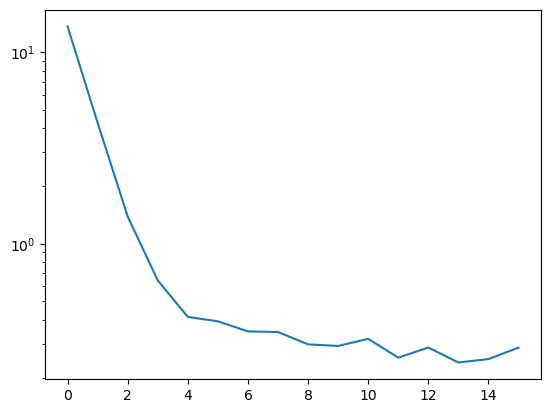

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:13<04:10, 13.18s/it]

 10%|█         | 2/20 [00:27<04:10, 13.91s/it]

 15%|█▌        | 3/20 [00:43<04:15, 15.01s/it]

 20%|██        | 4/20 [00:57<03:54, 14.63s/it]

 25%|██▌       | 5/20 [01:12<03:36, 14.45s/it]

 30%|███       | 6/20 [01:26<03:21, 14.39s/it]

 35%|███▌      | 7/20 [01:40<03:04, 14.17s/it]

 40%|████      | 8/20 [01:54<02:51, 14.32s/it]

 45%|████▌     | 9/20 [02:09<02:39, 14.53s/it]

 50%|█████     | 10/20 [02:26<02:33, 15.35s/it]

 55%|█████▌    | 11/20 [02:56<02:58, 19.85s/it]

 60%|██████    | 12/20 [03:24<02:57, 22.23s/it]

 65%|██████▌   | 13/20 [03:47<02:36, 22.38s/it]

 70%|███████   | 14/20 [04:11<02:18, 23.06s/it]

 75%|███████▌  | 15/20 [04:42<02:06, 25.24s/it]

 80%|████████  | 16/20 [05:09<01:43, 25.98s/it]

 85%|████████▌ | 17/20 [05:37<01:19, 26.38s/it]

 90%|█████████ | 18/20 [06:04<00:53, 26.52s/it]

 95%|█████████▌| 19/20 [06:27<00:25, 25.43s/it]

100%|██████████| 20/20 [06:53<00:00, 25.73s/it]

100%|██████████| 20/20 [06:53<00:00, 20.67s/it]

Test Loss: 0.3344


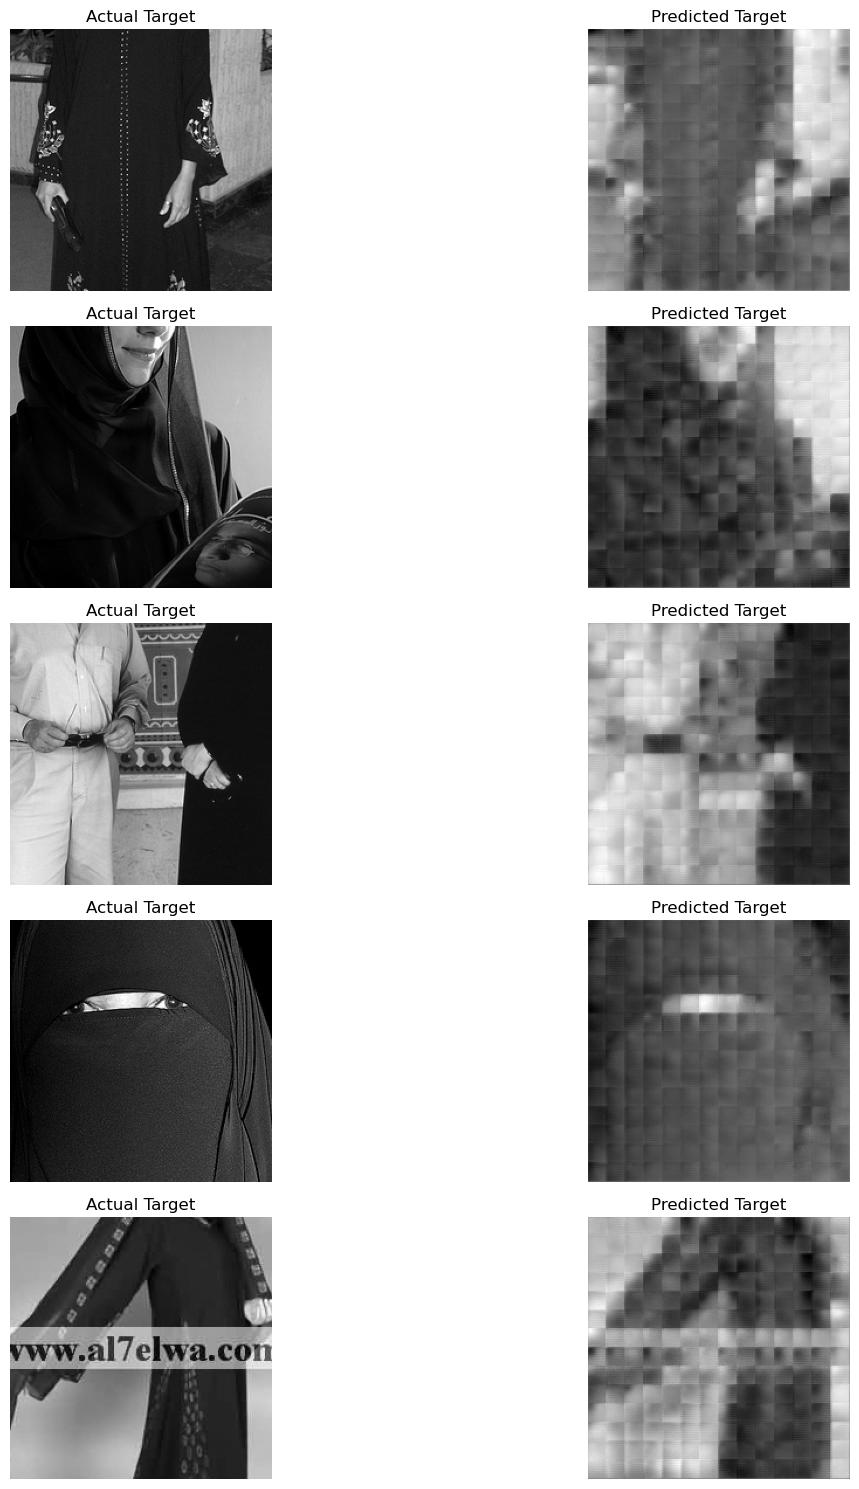

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-3.8975) tensor(4.2785)


tensor(-2.0337) tensor(2.3987)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))